<a href="https://colab.research.google.com/github/DaverArenas/DeepLearning_ImageClassification/blob/main/ClasificacionCancerPulmon_TransferenciaConocimiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transferencia de conocimiento

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Existen varias redes ya entrenadas para otros casos que pueden ser reusadas para clasificación, reusando los pesos ya entrenados de algunas de sus capas. Específicamente de las capas que se encargan de extraer rasgos importantes de los objetos.

## Datos de cáncer de pulmón
Se van a usar algunas imágenes para poder hacer la clasificación en subtipos de carcinomas pulmonares de células no-pequeñas:


*   **Adenocarcinoma**
*   Carcinoma pulmonar de células grandes (**large cell carcinoma**)
*   Carcinoma espinocelular (**squamous cell carcinoma**)

Y además hay algunas imágenes sin cáncer (**Normal**)



In [ ]:
from sklearn.datasets import load_files       
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import seaborn as sns
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D,MaxPooling2D, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
import os

In [ ]:
!unzip '/content/drive/MyDrive/Especializacion BigData EIA/AnaliticadeDatosBIBD/DatasetsAnalytics/CancerPulmon.zip'

Archive:  /content/drive/MyDrive/Especializacion BigData EIA/AnaliticadeDatosBIBD/DatasetsAnalytics/CancerPulmon.zip
replace CancerPulmon/test/adenocarcinoma/000108 (3).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import glob

In [ ]:
adenocarcinoma = glob.glob("/content/CancerPulmon/train/adenocarcinoma/*.png")
normal= glob.glob("/content/CancerPulmon/train/normal/*.png")
large_cell=glob.glob("/content/CancerPulmon/train/large.cell.carcinoma/*.png")
squamous_cell=glob.glob("/content/CancerPulmon/train/squamous.cell.carcinoma/*.png")

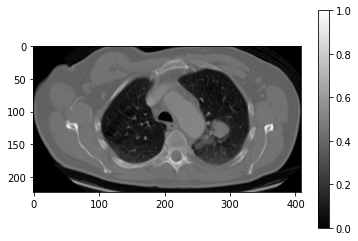

In [ ]:
img = plt.imread(adenocarcinoma[0])
plt.gray()
plt.imshow(img)
plt.grid(False)
plt.colorbar()

In [ ]:
img.shape

(224, 409, 4)

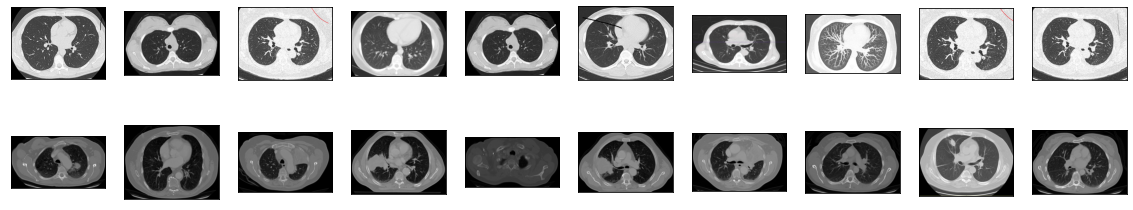

In [ ]:
plt.figure(figsize=(20, 4))
for i, (im1, im2) in enumerate(zip(normal[0:10], adenocarcinoma[0:10])):
  ax = plt.subplot(2, 10, i + 1)
  plt.imshow(plt.imread(im1))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(2, 10, i + 1 + 10)
  plt.imshow(plt.imread(im2))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

## Cargar los datos

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
batch_size=64
train_it = datagen.flow_from_directory('/content/CancerPulmon/train', class_mode='categorical', batch_size=batch_size, target_size=(224, 224))
test_it = datagen.flow_from_directory('/content/CancerPulmon/test', class_mode='categorical', batch_size=batch_size, target_size=(224, 224), shuffle=False)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


## VGG-16

La base de datos VGG16 es una red que se utiliza mucho en clasificación, haciendo transferencia de conocimiento, ha msotrado tener buen poder de extración de rasgos.

Fue entrenada para clasificar 1000 objetos diferentes y utiliza una entrada de 224x224 con canal RGB.

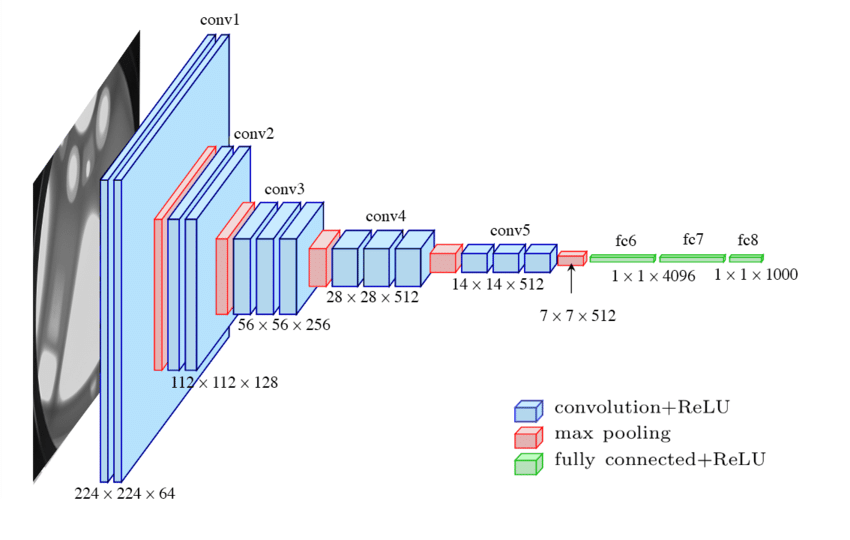
Tomada de: https://www.researchgate.net/publication/322512435_Automatic_localization_of_casting_defects_with_convolutional_neural_networks


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import SGD
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D,MaxPooling2D, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from tensorflow.keras.utils import plot_model

In [ ]:
model = VGG16()

In [ ]:
plot_model(model,show_shapes=True)

In [ ]:
modelWT = VGG16(include_top=False, input_shape=(224, 224, 3))

In [ ]:
modelWT.inputs

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_2')>]

In [ ]:
plot_model(modelWT,show_shapes=True)

In [ ]:
model.summary()

Ejercicio 1: Cree a partir de VGG16 un modelo para este problema. Recuerde que debe cargar el modelo sin el top, adicionar alguna capas y crear el modelo

In [ ]:
model_VGG16 = VGG16(include_top=False, input_shape=(224, 224, 3))
for layer in model_VGG16.layers:
  layer.trainable = False
x = Flatten()(model_VGG16.output)
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
output = Dense(4, activation='softmax')(x)


In [ ]:
model_VGG16 = Model(inputs=model_VGG16.inputs, outputs=output)

opt = SGD(learning_rate=0.001, momentum=0.9)
model_VGG16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_VGG16.fit(train_it,validation_data=test_it,epochs=10)

**Utilice el conjunto de prueba para ver cuán bueno es el modelo. Muestre la matriz de confusión y las métricas**

## VGG-19
Esta es otra red que surge como una variación de la anterior, también entrenada con entradas de 224x224 e imágenes RGB

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
model_VGG19 = VGG19(include_top=False, input_shape=(224, 224, 3))
for layer in model_VGG19.layers:
  layer.trainable = False
x = Flatten()(model_VGG19.output)
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
output = Dense(4, activation='softmax')(x)

model_VGG19 = Model(inputs=model_VGG19.inputs, outputs=output)

opt = SGD(lr=0.001, momentum=0.9)
model_VGG19.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

80150528/80134624 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history = model_VGG19.fit(train_it, steps_per_epoch=len(train_it),
                              validation_data=test_it, validation_steps=len(test_it), 
                              epochs=5, verbose=1)

**Ejercicio 2**: Haga un modelo, usando la red VGG-19 y transferencia de conocmiento, para entrenar los mismos datos.

## Inception V3

Esta es otra red entrenada con entradas de 299x299 e imágenes RGB.

Para ejecutar esta debe volver a cargar las imágenes, ahora con este tamaño, o si las imágenes son más pequeñas tmabién se podría poner el input de la red más pequeño.

In [ ]:
from tensorflow.keras.applications import InceptionV3

In [ ]:
batch_size=64
train_it_1 = datagen.flow_from_directory('/content/CancerPulmon/train', class_mode='categorical', batch_size=batch_size, target_size=(299, 299))
test_it_1 = datagen.flow_from_directory('/content/CancerPulmon/test', class_mode='categorical', batch_size=batch_size, target_size=(299, 299), shuffle=False)

In [ ]:
model_Inception = InceptionV3(include_top=False, input_shape=(299, 299, 3))
model_Inception.summary()

In [ ]:
model = InceptionV3(include_top=False, input_shape=(299, 299, 3))
for layer in model.layers:
  layer.trainable = False
x = Flatten()(model.output)
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
output = Dense(4, activation='softmax')(x)
model = Model(inputs=model.inputs, outputs=output)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_it_1, steps_per_epoch=len(train_it_1),
                              validation_data=test_it_1, validation_steps=len(test_it_1), 
                              epochs=10, verbose=1)

Recuerde que en inception debe volver a cargar los datos con tamaño 299x299